# Final Project

## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

## Your assignment

Apply several different supervised machine learning techniques to this data set, and see which one yields the highest accuracy as measured with K-Fold cross validation (K=10). Apply:

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression
* And, as a bonus challenge, a neural network using Keras.

The data needs to be cleaned; many rows contain missing data, and there may be erroneous data identifiable as outliers as well.

Remember some techniques such as SVM also require the input data to be normalized first.

Many techniques also have "hyperparameters" that need to be tuned. Once you identify a promising approach, see if you can make it even better by tuning its hyperparameters.

I was able to achieve over 80% accuracy - can you beat that?

Below I've set up an outline of a notebook for this project, with some guidance and hints. If you're up for a real challenge, try doing this project from scratch in a new, clean notebook!


## Let's begin: prepare your data

Start by importing the mammographic_masses.data.txt file into a Pandas dataframe (hint: use read_csv) and take a look at it.

In [35]:
import pandas as pd
import numpy as np

headers = ['BI_RADS','age','shape','margin','density','severity']
raw_data = pd.read_csv('C:/Users/Bertrand.Marechal/Documents/Projects/GitHubBertrand/Udemy-ML-DL/DataScience-Python3/mammographic_masses.data.txt',
                      na_values=["?"],
                      header=None,
                      names=headers)
raw_data.head()

,BI_RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


Make sure you use the optional parmaters in read_csv to convert missing data (indicated by a ?) into NaN, and to add the appropriate column names (BI_RADS, age, shape, margin, density, and severity):

In [36]:
raw_data.head()

,BI_RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


Evaluate whether the data needs cleaning; your model is only as good as the data it's given. Hint: use describe() on the dataframe.

In [37]:
raw_data.describe()

,BI_RADS,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


There are quite a few missing values in the data set. Before we just drop every row that's missing data, let's make sure we don't bias our data in doing so. Does there appear to be any sort of correlation to what sort of data has missing fields? If there were, we'd have to try and go back and fill that data in.

If the missing data seems randomly distributed, go ahead and drop rows with missing data. Hint: use dropna().

In [38]:
raw_data = raw_data.dropna()
raw_data.describe()

,BI_RADS,age,shape,margin,density,severity
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663,0.485542
std,1.888371,14.671782,1.242361,1.567175,0.350936,0.500092
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Next you'll need to convert the Pandas dataframes into numpy arrays that can be used by scikit_learn. Create an array that extracts only the feature data we want to work with (age, shape, margin, and density) and another array that contains the classes (severity). You'll also need an array of the feature name labels.

In [55]:
feature_columns = list(raw_data.columns[1:5])
X = raw_data[feature_columns]
raw_data.head()
Y = raw_data["severity"]

Some of our models require the input data to be normalized, so go ahead and normalize the attribute data. Hint: use preprocessing.StandardScaler().

In [66]:
from sklearn import tree
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)


## Decision Trees

Before moving to K-Fold cross validation and random forests, start by creating a single train/test split of our data. Set aside 75% for training, and 25% for testing.

In [67]:
X_train = X[:75]
Y_train = Y[:75]
X_test = X[75:]
Y_test = Y[75:]

Now create a DecisionTreeClassifier and fit it to your training data.

In [68]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train,Y_train)

Display the resulting decision tree.

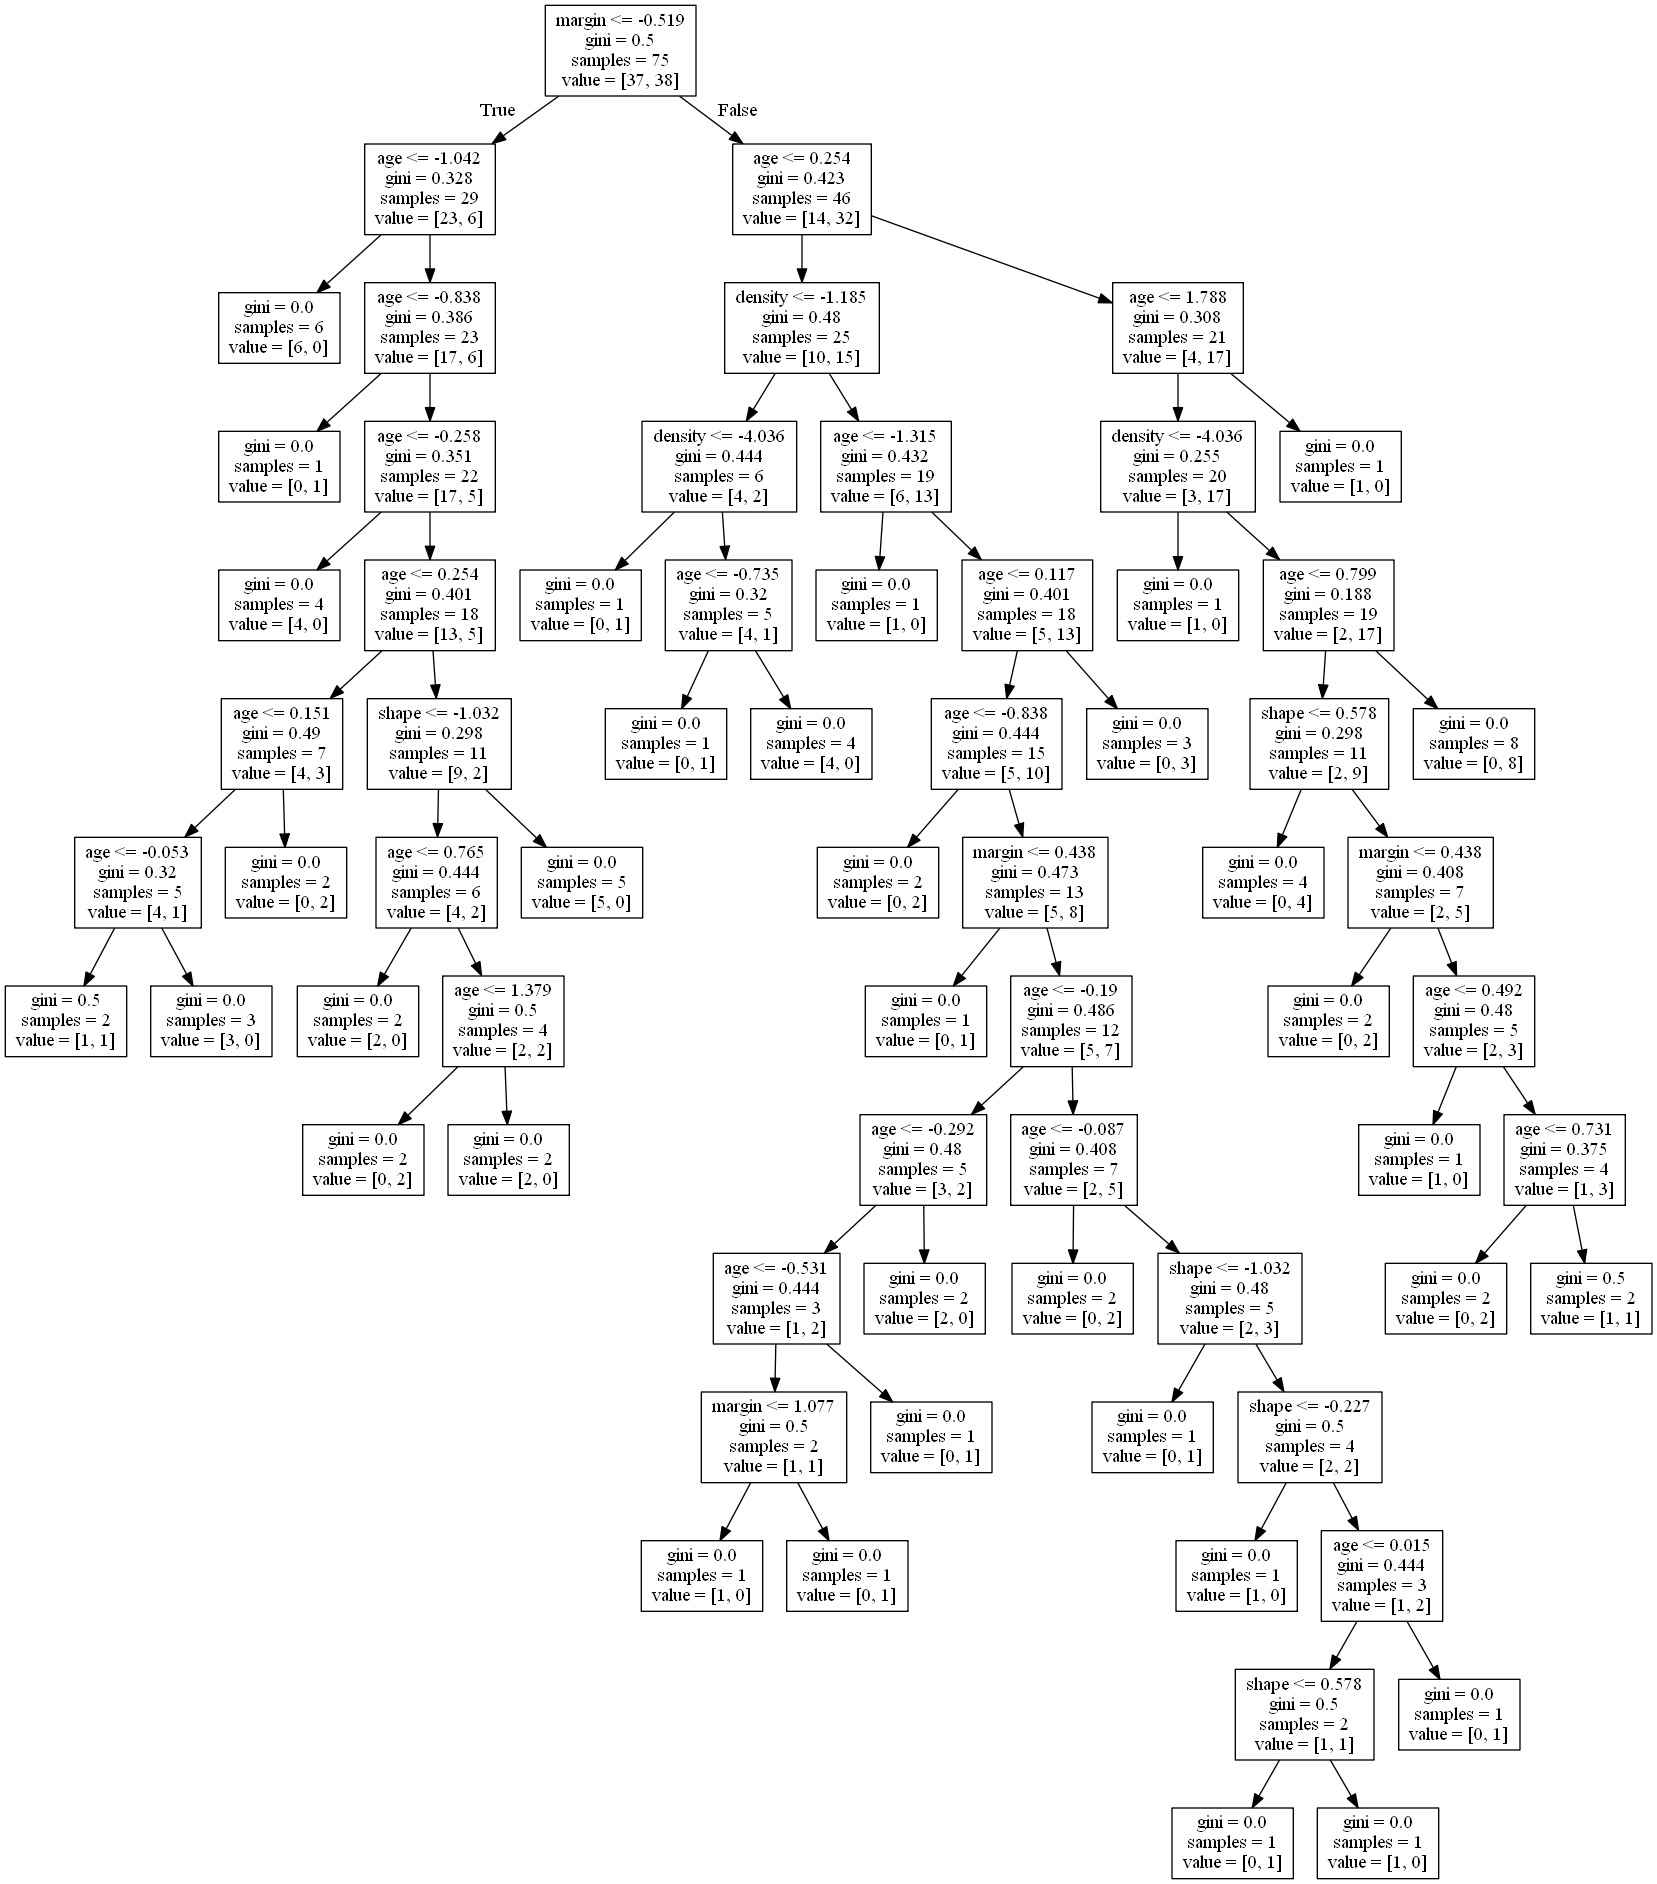

In [71]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydotplus

dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=feature_columns)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

Measure the accuracy of the resulting decision tree model using your test data.

In [72]:
clf.score(X_test, Y_test)

0.67549668874172186

Now instead of a single train/test split, use K-Fold cross validation to get a better measure of your model's accuracy (K=10). Hint: use model_selection.cross_val_score

In [110]:
from sklearn.model_selection import cross_val_score
global_scores = {}
def show_scores(p_type, p_clf, p_X, p_Y, p_cv):
    scores = cross_val_score(p_clf, p_X, p_Y, cv=p_cv)

    # Print the accuracy for each fold:
    # print(scores)

    # And the mean accuracy of all 10 folds:
    print('score for {0}: {1}'.format(p_type, scores.mean()))
    global_scores[p_type] = scores.mean()
    return float(scores.mean())
    
show_scores('single-decision-tree',clf, X, Y, 10)

score for single-decision-tree: 0.744454472944041


0.744454472944041

Now try a RandomForestClassifier instead. Does it perform better?

In [116]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
show_scores('random-forest',clf, X, Y, 10)

score for random-forest: 0.7566051663098385


0.7566051663098385

## SVM

Next try using svm.SVC with a linear kernel. How does it compare to the decision tree?

In [117]:
from sklearn import svm, datasets

C = 1.0
svc = svm.SVC(kernel='linear', C=C)

show_scores('svc-linear',svc, X, Y, 10)

score for svc-linear: 0.7964988875362076


0.7964988875362076

In [113]:
# better than decision tree

## KNN
How about K-Nearest-Neighbors? Hint: use neighbors.KNeighborsClassifier - it's a lot easier than implementing KNN from scratch like we did earlier in the course. Start with a K of 10. K is an example of a hyperparameter - a parameter on the model itself which may need to be tuned for best results on your particular data set.

In [114]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)
show_scores('knn-10',neigh, X, Y, 10)

score for knn-10: 0.7854795488574507


0.7854795488574507

Choosing K is tricky, so we can't discard KNN until we've tried different values of K. Write a for loop to run KNN with K values ranging from 1 to 50 and see if K makes a substantial difference. Make a note of the best performance you could get out of KNN.

In [115]:
max_knn = [0, 0.0]
for x in range(1, 50):
    neigh = KNeighborsClassifier(n_neighbors=x)
    neigh.fit(X, Y)
    mean = float(show_scores('knn-{0}'.format(x),neigh, X, Y, 10))
    if (mean > max_knn[1]):
        max_knn = [x, mean]
'Max for {0} : {1}'.format(max_knn[0],max_knn[1])    

score for knn-1: 0.72270755495851
score for knn-2: 0.6877789905265661
score for knn-3: 0.7540933769922896
score for knn-4: 0.7300522648083623
score for knn-5: 0.7747512698879141
score for knn-6: 0.7674069098694429
score for knn-7: 0.7964838447868128
score for knn-8: 0.7771178791822342
score for knn-9: 0.7892248436253726
score for knn-10: 0.7854795488574507
score for knn-11: 0.790342904719925
score for knn-12: 0.7782639267872884
score for knn-13: 0.7819371562906678
score for knn-14: 0.7867130543078237
score for knn-15: 0.7842600366623288
score for knn-16: 0.7770311209996781
score for knn-17: 0.7842607363250913
score for knn-18: 0.7780907602535578
score for knn-19: 0.7829100373619916
score for knn-20: 0.7816618389936051
score for knn-21: 0.7853927906748946
score for knn-22: 0.779295229699285
score for knn-23: 0.7805588206484475
score for knn-24: 0.780587506821712
score for knn-25: 0.7890366343422469
score for knn-26: 0.7854074835929084
score for knn-27: 0.7842317003204455
score for knn-2

'Max for 7 : 0.7964838447868128'

## Naive Bayes

Now try naive_bayes.MultinomialNB. How does its accuracy stack up? Hint: you'll need to use MinMaxScaler to get the features in the range MultinomialNB requires.

In [122]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
nb_X = scaler.transform(X)

classifier = MultinomialNB()
classifier.fit(nb_X, Y)
show_scores('naive-bayes',classifier, nb_X, Y, 10)

score for naive-bayes: 0.7844055665169388


0.7844055665169388

## Revisiting SVM

svm.SVC may perform differently with different kernels. The choice of kernel is an example of a "hyperparamter." Try the rbf, sigmoid, and poly kernels and see what the best-performing kernel is. Do we have a new winner?

In [126]:
svc = svm.SVC(kernel='rbf', C=C)
show_scores('svc-rbf',svc, X, Y, 10)

score for svc-rbf: 0.8012023704574396


0.8012023704574396

In [127]:
svc = svm.SVC(kernel='sigmoid', C=C)
show_scores('svc-sigmoid',svc, X, Y, 10)

score for svc-sigmoid: 0.7351055791108685


0.7351055791108685

In [129]:
max_poly = [0, 0.0]
for x in range(1, 7):
    svc = svm.SVC(kernel='poly', C=C, degree=x)
    mean = float(show_scores('svc-poly-{0}'.format(x),svc, X, Y, 10))
    if (mean > max_poly[1]):
        max_poly = [x, mean]
'Max for {0} : {1}'.format(max_poly[0],max_poly[1])  

score for svc-poly-1: 0.7989375620950702
score for svc-poly-2: 0.6389008997663126
score for svc-poly-3: 0.792753942599667
score for svc-poly-4: 0.6854998390775646
score for svc-poly-5: 0.760321774904496
score for svc-poly-6: 0.6987105215286231


'Max for 1 : 0.7989375620950702'

## Logistic Regression

We've tried all these fancy techniques, but fundamentally this is just a binary classification problem. Try Logisitic Regression, which is a simple way to tackling this sort of thing.

In [132]:
from sklearn.linear_model import LogisticRegression

logistic_regression_methods = ['newton-cg','lbfgs','liblinear','sag','saga']
max_poly = [0, 0.0]
for x in logistic_regression_methods:
    clf = LogisticRegression(solver=x)
    mean = float(show_scores('logistic-regression-{0}'.format(x),clf, X, Y, 10))
    if (mean > max_poly[1]):
        max_poly = [x, mean]
'Max for {0} : {1}'.format(max_poly[0],max_poly[1])

score for logistic-regression-newton-cg: 0.8073583532737221
score for logistic-regression-lbfgs: 0.8073583532737221
score for logistic-regression-liblinear: 0.8073583532737221
score for logistic-regression-sag: 0.8073583532737221
score for logistic-regression-saga: 0.8073583532737221


'Max for newton-cg : 0.8073583532737221'

## Neural Networks

As a bonus challenge, let's see if an artificial neural network can do even better. You can use Keras to set up a neural network with 1 binary output neuron and see how it performs. Don't be afraid to run a large number of epochs to train the model if necessary.

In [142]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def create_model():
    model = Sequential()
    model.add(Dense(16, activation='relu', input_dim=4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

model = create_model()
history = model.fit(
    X_train,
    Y_train,
    batch_size=100,
    epochs=500,
    verbose=1,
    validation_data=(X_test, Y_test))
    
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

global_scores['neural-network']=score[1]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 16)                80        
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 17        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
Train on 75 samples, validate on 755 samples
Epoch 1/500
75/75 [==============================] - 1s 9ms/step - loss: 0.8265 - acc: 0.5733 - val_loss: 0.7018 - val_acc: 0.4755
Epoch 2/500
75/75 [==============================] - 0s 93us/step - loss: 0.7623 - acc: 0.5067 - val_loss: 0.6935 - val_acc: 0.5152
Epoch 3/500
75/75 [==============================] - 0s 93us/step - loss: 0.7529 - acc: 0.5200 - val_l

## Do we have a winner?

Which model, and which choice of hyperparameters, performed the best? Feel free to share your results!

In [156]:
scores_list = []

class Score(object):
    key = ""
    score = ""
    def __init__(self, key, value):
        self.key = key
        self.score = value
    def print_score(self):
        '{0}: {1}'.format(self.key, self.score)

global_scores['neural-network']
for x in global_scores:
    scores_list.append(Score(x, global_scores[x]))
scores_list.sort(key=lambda x: x.score, reverse=True);

print('Top 10 methods')
for x in range(0,10):
    